# Load Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller

In [35]:
def load_dataset(path):
    #read csv file 
    df = pd.read_csv(path, index_col='Date', parse_dates=True)

    ts = df['Close']
    ts=ts.interpolate(method='time')
    ts[ts.isna()]

    ts_log = np.log(ts)
    return ts_log 

def plot_rolling_statistics(timeseries, window=365):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def train_and_test(data):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
    plt.show()
    return train_data, test_data

def plot_show(data):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log) # PACF : Partial Autocorrelation 그래프 그리기

def diff(data):
        
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')
    
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')
    print("df1",augmented_dickey_fuller_test(diff_1))
    print("df2",augmented_dickey_fuller_test(diff_2))

# Tesla

In [22]:
Tesla='/content/TSLA.csv'

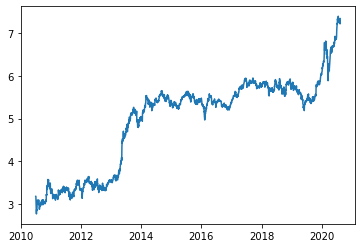

In [23]:
ts_log = load_dataset(Tesla)
plt.plot(ts_log)

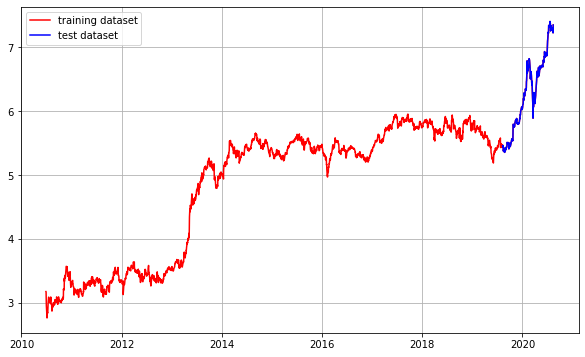

In [36]:
train_data,test_data =train_and_test(ts_log)

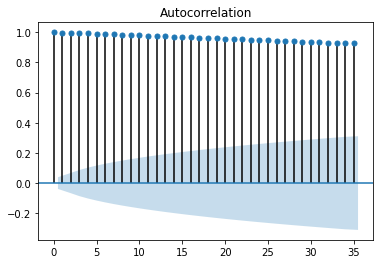

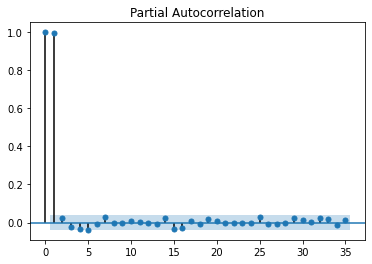

In [27]:
plot_show(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -49.770501
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2547.000000
Critical Value (1%)              -3.432920
Critical Value (5%)              -2.862675
Critical Value (10%)             -2.567374
dtype: float64
df1 None
Results of Dickey-Fuller Test:
Test Statistic                -1.587017e+01
p-value                        9.000856e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.519000e+03
Critical Value (1%)           -3.432949e+00
Critical Value (5%)           -2.862688e+00
Critical Value (10%)          -2.567381e+00
dtype: float64
df2 None


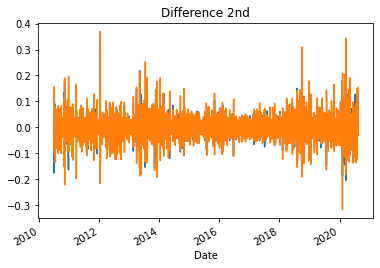

In [34]:
a=diff(ts_log)

In [67]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(0, 1 ,1))  
fitted_m = model.fit(trend='c')  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2293
Model:                 ARIMA(0, 1, 1)   Log Likelihood                4614.090
Method:                       css-mle   S.D. of innovations              0.032
Date:                Thu, 13 Aug 2020   AIC                          -9222.180
Time:                        06:44:32   BIC                          -9204.967
Sample:                             1   HQIC                         -9215.903
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      1.483      0.138      -0.000       0.002
ma.L1.D.Close     0.0015      0.021      0.072      0.942      -0.040       0.043
                                    Root

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


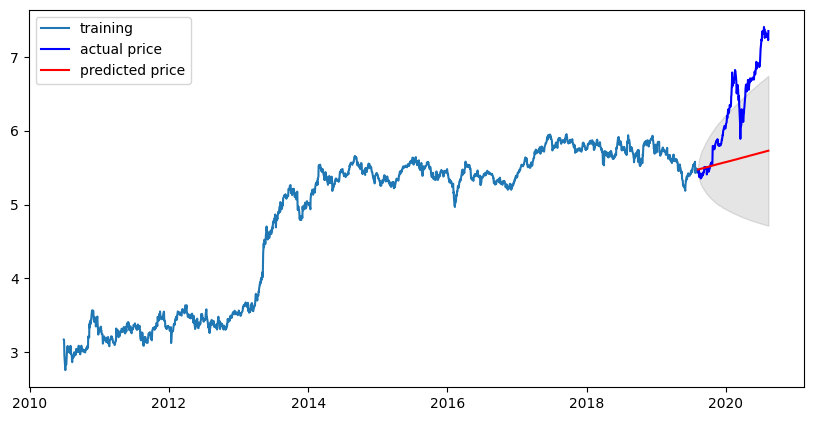

In [68]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [69]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  268242.0204864133
MAE:  370.26863679695356
RMSE:  517.9208631503594
MAPE: 43.85%


# Google

In [96]:
Google='/content/GOOGL.csv'

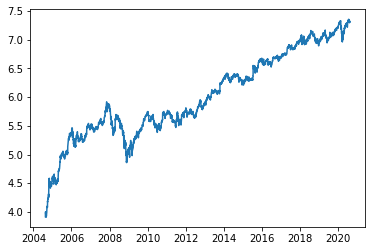

In [97]:
ts_log = load_dataset(Google)
plt.plot(ts_log)

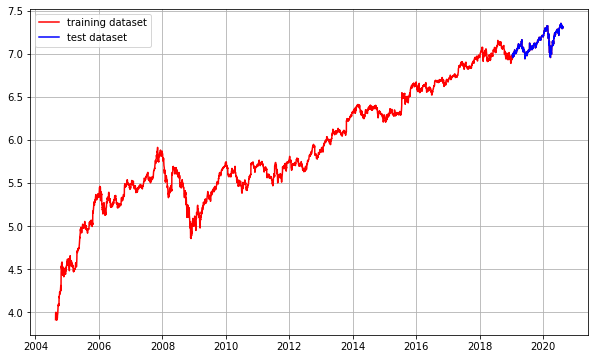

In [98]:
train_data,test_data =train_and_test(ts_log)

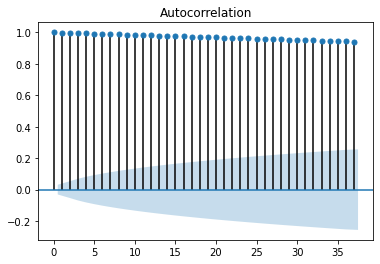

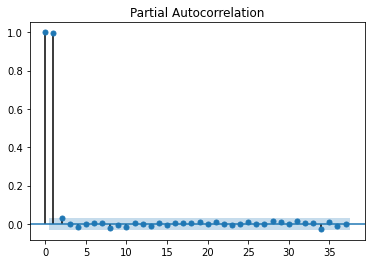

In [99]:
plot_show(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                -1.757163e+01
p-value                        4.048778e-30
#Lags Used                     1.100000e+01
Number of Observations Used    4.011000e+03
Critical Value (1%)           -3.431981e+00
Critical Value (5%)           -2.862261e+00
Critical Value (10%)          -2.567154e+00
dtype: float64
df1 None
Results of Dickey-Fuller Test:
Test Statistic                  -20.251111
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    3990.000000
Critical Value (1%)              -3.431990
Critical Value (5%)              -2.862265
Critical Value (10%)             -2.567156
dtype: float64
df2 None


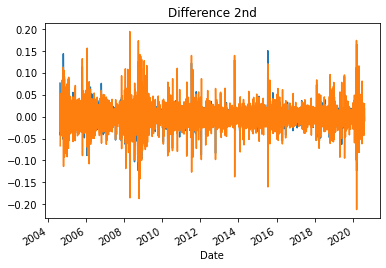

In [100]:
a=diff(ts_log)

In [101]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(0, 1 ,1))  
fitted_m = model.fit(trend='c')  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3620
Model:                 ARIMA(0, 1, 1)   Log Likelihood                9215.439
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 13 Aug 2020   AIC                         -18424.878
Time:                        06:47:57   BIC                         -18406.295
Sample:                             1   HQIC                        -18418.257
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.661      0.008       0.000       0.001
ma.L1.D.Close     0.0090      0.017      0.537      0.591      -0.024       0.042
                                    Root

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


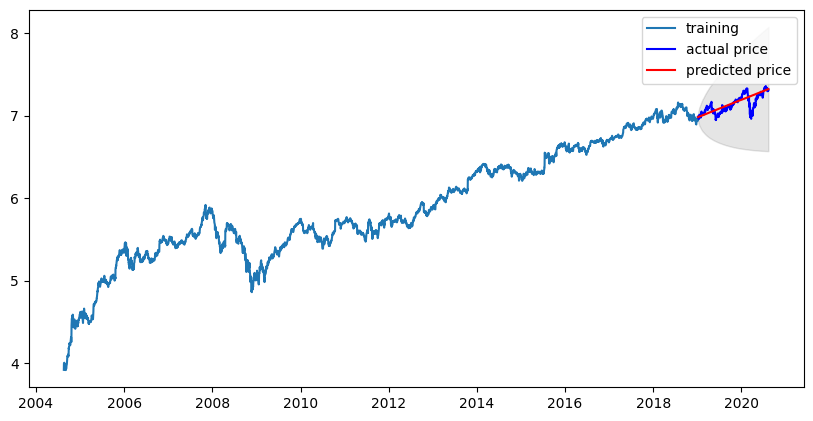

In [102]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [103]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8158.176733399033
MAE:  64.09072400072472
RMSE:  90.32262581102829
MAPE: 5.20%


# Amazon

In [70]:
Amazon='/content/AMZN.csv'

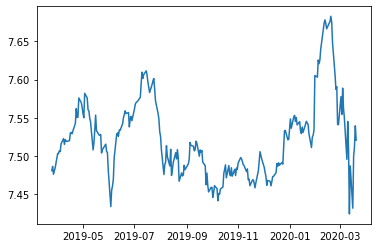

In [71]:
ts_log = load_dataset(Amazon)
plt.plot(ts_log)

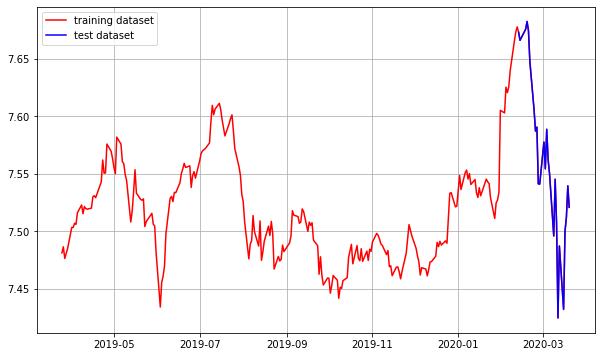

In [72]:
train_data,test_data =train_and_test(ts_log)

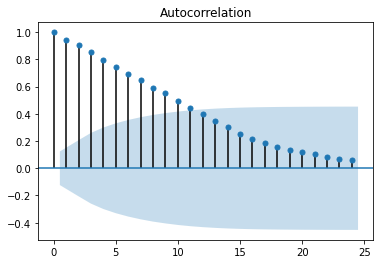

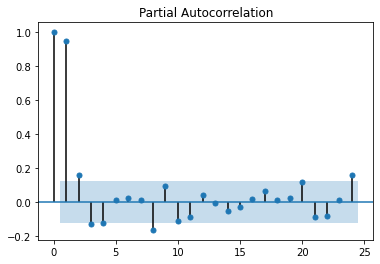

In [73]:
plot_show(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -4.707815
p-value                          0.000081
#Lags Used                       8.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64
df1 None
Results of Dickey-Fuller Test:
Test Statistic                -9.034264e+00
p-value                        5.341765e-15
#Lags Used                     8.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
df2 None


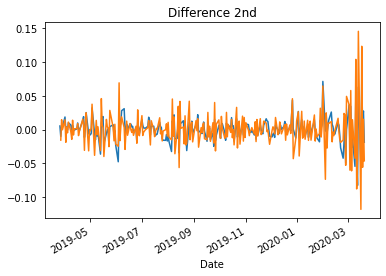

In [74]:
a=diff(ts_log)

In [89]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(2, 1 ,0))  
fitted_m = model.fit(trend='c')  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 651.965
Method:                       css-mle   S.D. of innovations              0.013
Date:                Thu, 13 Aug 2020   AIC                          -1295.931
Time:                        06:47:01   BIC                          -1282.284
Sample:                             1   HQIC                         -1290.422
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      0.962      0.337      -0.001       0.003
ar.L1.D.Close    -0.0099      0.067     -0.149      0.882      -0.140       0.121
ar.L2.D.Close     0.0466      0.067     

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


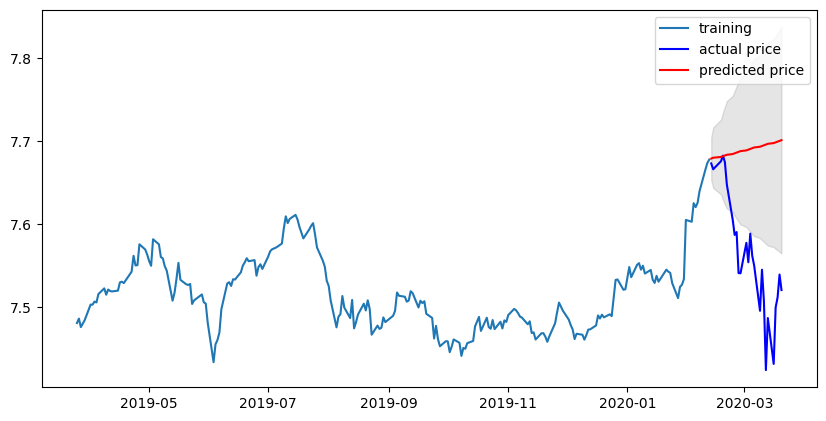

In [90]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [91]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  86967.83955464038
MAE:  253.0226488098894
RMSE:  294.90310197527657
MAPE: 13.71%
